In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

In [2]:
# generate data
kernel = jnp.ones(5)/5

n, p = 500, 100
rng0 = 100
key1 = random.PRNGKey(rng0 + 1)
key2 = random.PRNGKey(rng0 + 2)
key3 = random.PRNGKey(rng0 + 3)

t = jnp.linspace(0, 1, p + 8)
s = jnp.linspace(-2*math.pi, 2*math.pi, n + 1)

amp = jnp.sin(s)
sd = jnp.sin(s)

f = jnp.sin(2 * math.pi * t)
f = 10 + amp[:,None] * f[None,:]

xtrain = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key1, f.shape)
xtrain = conv(conv(xtrain.squeeze(), kernel), kernel)
xtrain, ytrain = split_data(xtrain, 1, 1)
xtrain = xtrain[:,:,:,None]
ytrain = ytrain[:,:,:,None]

xval = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key2, f.shape)
xval = conv(conv(xval.squeeze(), kernel), kernel)

xval, yval = split_data(xval, 1, 1)
xval = xval[:,:,:,None]
yval = yval[:,:,:,None]

xtest = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key3, f.shape)
xtest = conv(conv(xtest.squeeze(), kernel), kernel)

xtest, ytest = split_data(xtest, 1, 1)
xtest = xtest[:,:,:,None]
ytest = ytest[:,:,:,None]

sigma = 0.25 * (1.15 + sd)

In [3]:
train_data = TensorDataset(jax2torch(xtrain), jax2torch(ytrain))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [4]:
epochs = 50
trace = []
lag, lead = 1, 1

width = 50
drop_prob = 0.1

rng = random.PRNGKey(0)
model_rng = nnx.Rngs(0)
base_model = DeepANO(lag, width, lead, rngs=model_rng)
drop_model = DropANO(lag, width, lead, drop_prob, rngs=model_rng)
prob_model = ProbANO(lag, width, lead, rngs=model_rng)
quant_model = DeepANO(lag, width, lead, rngs=model_rng)

base_optim = nnx.Optimizer(base_model, optax.adam(1e-3))
drop_optim = nnx.Optimizer(drop_model, optax.adam(1e-3))
prob_optim = nnx.Optimizer(prob_model, optax.adam(1e-3))
quant_optim = nnx.Optimizer(quant_model, optax.adam(1e-3))

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        base_loss = train_step(base_model, base_optim, xt, yt)
        drop_loss = train_step(drop_model, drop_optim, xt, yt)
        prob_loss = prob_step(prob_model, prob_optim, xt, yt)
        quant_loss = quant_step(quant_model, quant_optim, xt, yt)

  0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
yval_hat = base_model(xval)
ytest_hat = base_model(xtest)

yval_quant = quant_model(xval)
ytest_quant = quant_model(xtest)

yval_mu, yval_sd = prob_model(xval)
ytest_mu, ytest_sd = prob_model(xtest)

In [6]:
yval = yval.squeeze()
ytest = ytest.squeeze()

yval_hat = yval_hat.squeeze()
ytest_hat = ytest_hat.squeeze()
yval_quant = yval_quant.squeeze()
ytest_quant = ytest_quant.squeeze()
yval_mu = yval_mu.squeeze()
yval_sd = yval_sd.squeeze()
ytest_mu = ytest_mu.squeeze()
ytest_sd = ytest_sd.squeeze()

In [7]:
nproj = npc = 50
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]

drop_risk, drop_width = [], []
orcl_risk, orcl_width = [], []
conf_risk, conf_width = [], []
gaus_risk, gaus_width = [], []
supr_risk, supr_width = [], []
uqn1_risk, uqn1_width = [], []
pdon_risk, pdon_width = [], []
qdon_risk, qdon_width = [], []
lsc1_risk, lsc1_width = [], []
lsc2_risk, lsc2_width = [], []

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()
rtest2 = (ytest - ytest_mu).squeeze()

state = lsci.lsci_state(xval, rval, npc)
pca_state = state[-1]

quant_scores = jnp.abs(yval - yval_hat) / yval_quant
lam_uqno = uqno.estimate_lambda(quant_scores, 0.1, 0.01, 1.1)

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
gaus_lower, gaus_upper = gaus.gaus_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)
pdon_lower, pdon_upper = prob_don.prob_don(prob_model, xval, xtest, yval, alpha)
qdon_lower, qdon_upper = quant_don.quant_don(quant_model, xval, xtest, yval - yval_hat, alpha)

for i in trange(0, ytest.shape[0]):
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma1)
    lsc1_risk.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma2)
    lsc2_risk.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))

    # Oracle
    orcl_lower = -(jnp.abs(rtest[i]) + 1e-4)
    orcl_upper = jnp.abs(rtest[i]) + 1e-4
    orcl_risk.append(risk(orcl_lower, orcl_upper, rtest[i]))
    orcl_width.append(jnp.median(orcl_upper - orcl_lower))
    
    # CONF 
    conf_risk.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.median(conf_upper - conf_lower))
    
    # GAUSS 
    gaus_risk.append(risk(gaus_lower, gaus_upper, rtest[i]))
    gaus_width.append(jnp.median(gaus_upper - gaus_lower))
    
    # SUPR
    supr_risk.append(risk(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.median(supr_upper - supr_lower))
    
    # UQNO
    uqn1_risk.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.median(uqn1_upper[i] - uqn1_lower[i]))
    
    # PDON
    pdon_risk.append(risk(pdon_lower[i], pdon_upper[i], rtest2[i]))
    pdon_width.append(jnp.median(pdon_upper[i] - pdon_lower[i]))
    
    # PDON
    qdon_risk.append(risk(qdon_lower[i], qdon_upper[i], rtest[i]))
    qdon_width.append(jnp.median(qdon_upper[i] - qdon_lower[i]))
    
    # DROPOUT
    drop_model.train()
    drop_set = jnp.stack([drop_model(xtest[i:(i+1)]).squeeze() for _ in range(500)])
    drop_lower = jnp.quantile(drop_set, alpha/2, axis = 0)
    drop_upper = jnp.quantile(drop_set, 1 - alpha/2, axis = 0)
    drop_model.eval()
    
    drop_risk.append(risk(drop_lower, drop_upper, rtest[i]))
    drop_width.append(jnp.median(drop_upper - drop_lower))


orcl_risk, orcl_width = np.array(orcl_risk), np.array(orcl_width)
drop_risk, drop_width = np.array(drop_risk), np.array(drop_width)
conf_risk, conf_width = np.array(conf_risk), np.array(conf_width)
gaus_risk, gaus_width = np.array(gaus_risk), np.array(gaus_width)
supr_risk, supr_width = np.array(supr_risk), np.array(supr_width)
uqn1_risk, uqn1_width = np.array(uqn1_risk), np.array(uqn1_width)
lsc1_risk, lsc1_width = np.array(lsc1_risk), np.array(lsc1_width)
lsc2_risk, lsc2_width = np.array(lsc2_risk), np.array(lsc2_width)
pdon_risk, pdon_width = np.array(pdon_risk), np.array(pdon_width)
qdon_risk, qdon_width = np.array(qdon_risk), np.array(qdon_width)

  0%|          | 0/500 [00:00<?, ?it/s]

In [8]:
noise_sd = sigma[1:]
gamma = 0.99

risk_control = np.mean(orcl_risk >= gamma), \
               np.mean(drop_risk >= gamma), \
               np.mean(conf_risk >= gamma), \
               np.mean(gaus_risk >= gamma), \
               np.mean(supr_risk >= gamma), \
               np.mean(uqn1_risk >= gamma), \
               np.mean(pdon_risk >= gamma), \
               np.mean(qdon_risk >= gamma), \
               np.mean(lsc1_risk >= gamma), \
               np.mean(lsc2_risk >= gamma)

width = np.mean(orcl_width), \
        np.mean(drop_width), \
        np.mean(conf_width), \
        np.mean(gaus_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(pdon_width), \
        np.mean(qdon_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = -0, \
           np.corrcoef([noise_sd, drop_risk])[0,1], \
           np.corrcoef([noise_sd, conf_risk])[0,1], \
           np.corrcoef([noise_sd, gaus_risk])[0,1], \
           np.corrcoef([noise_sd, supr_risk])[0,1], \
           np.corrcoef([noise_sd, uqn1_risk])[0,1], \
           np.corrcoef([noise_sd, pdon_risk])[0,1], \
           np.corrcoef([noise_sd, qdon_risk])[0,1], \
           np.corrcoef([noise_sd, lsc1_risk])[0,1], \
           np.corrcoef([noise_sd, lsc2_risk])[0,1]

width_cor = 1, \
            np.corrcoef([noise_sd, drop_width])[0,1], \
            0, \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, pdon_width])[0,1], \
            np.corrcoef([noise_sd, qdon_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

/Users/trevorharris/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/trevorharris/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [9]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(np.nan_to_num(metrics[i,j]), 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

1.000 & 0.000 & 0.202 & 1.000 \\
0.000 & 0.000 & 0.828 & -0.003 \\
0.868 & -0.465 & 1.250 & 0.000 \\
0.824 & -0.504 & 1.180 & 0.000 \\
0.926 & -0.363 & 1.447 & 0.000 \\
0.990 & -0.140 & 1.836 & 0.270 \\
0.440 & -0.862 & 0.583 & 0.644 \\
0.262 & -0.146 & 0.940 & 0.538 \\
0.942 & -0.002 & 0.930 & 0.993 \\
0.922 & -0.013 & 0.891 & 0.992 \\


In [22]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(np.nan_to_num(metrics[i,j]), 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

1.000 & 0.000 & 0.212 & 1.000 \\
0.000 & 0.000 & 1.022 & 0.050 \\
0.828 & -0.453 & 1.299 & 0.000 \\
0.782 & -0.508 & 1.190 & 0.000 \\
0.898 & -0.333 & 1.467 & 0.000 \\
0.992 & -0.119 & 1.851 & 0.052 \\
0.426 & -0.854 & 0.600 & -0.039 \\
0.270 & -0.102 & 1.015 & 0.520 \\
0.920 & -0.053 & 0.923 & 0.992 \\
0.904 & -0.043 & 0.893 & 0.992 \\


In [31]:
methods = ['Oracle', 'MC-Drop', 'Conf1', 'Conf2', 
           'Supr', 'CQR-NO', 'Prob-NO', 'Quant-NO', 
           'LSCI1', 'LSCI2']

for i in range(metrics.shape[0]):
    print(f'{methods[i]} & ', end = '')
    for j in range(metrics.shape[1]):
        val = f'{np.round(np.nan_to_num(metrics[i,j]), 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

Oracle & 1.000 & 0.000 & 0.212 & 1.000 \\
MC-Drop & 0.000 & 0.000 & 1.022 & 0.050 \\
Conf1 & 0.828 & -0.453 & 1.299 & 0.000 \\
Conf2 & 0.782 & -0.508 & 1.190 & 0.000 \\
Supr & 0.898 & -0.333 & 1.467 & 0.000 \\
CQR-NO & 0.992 & -0.119 & 1.851 & 0.052 \\
Prob-NO & 0.426 & -0.854 & 0.600 & -0.039 \\
Quant-NO & 0.270 & -0.102 & 1.015 & 0.520 \\
LSCI1 & 0.920 & -0.053 & 0.923 & 0.992 \\
LSCI2 & 0.904 & -0.043 & 0.893 & 0.992 \\


In [ ]:
width = np.mean(orcl_width), \
        np.mean(drop_width), \
        np.mean(conf_width), \
        np.mean(gaus_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(pdon_width), \
        np.mean(qdon_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

In [11]:
yval_hat = base_model(xval)
ytest_hat = base_model(xtest)

In [12]:
yval = yval.squeeze()
ytest = ytest.squeeze()

yval_hat = yval_hat.squeeze()
ytest_hat = ytest_hat.squeeze()

In [13]:
nproj = npc = 50
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()

state = lsci.lsci_state(xval, rval, npc)
pca_state = state[-1]

In [14]:
lsci_risk = []
for i in trange(500):
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma2)
    lsci_risk.append(risk(lsc1_lower, lsc1_upper, rtest[i]))

  0%|          | 0/500 [00:00<?, ?it/s]

In [15]:
np.mean(np.array(lsci_risk) >= 0.99)

0.906

In [16]:
lsci_risk = []
for i in trange(500):
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma1)
    lsci_risk.append(risk(lsc1_lower, lsc1_upper, rtest[i]))

  0%|          | 0/500 [00:00<?, ?it/s]

In [19]:
np.mean(np.array(lsci_risk) >= 0.99)

0.914

In [23]:
lsc1_ens = lsci.lsci(xtest[0].squeeze(), state, alpha, 2000, gamma1)

In [39]:
nsamp = 2000
npc = 50
alpha = 0.1

rval = (yval - yval_hat).squeeze()

xval = xval.squeeze()
rval = rval.squeeze()
xtest = xtest.squeeze()
state = lsci.lsci_state(xval, rval, npc)

In [40]:
lsc1_ens = lsci.lsci(xtest[0].squeeze(), state, alpha, 2000, gamma1)
lsc1_ens.shape

(2000, 100)

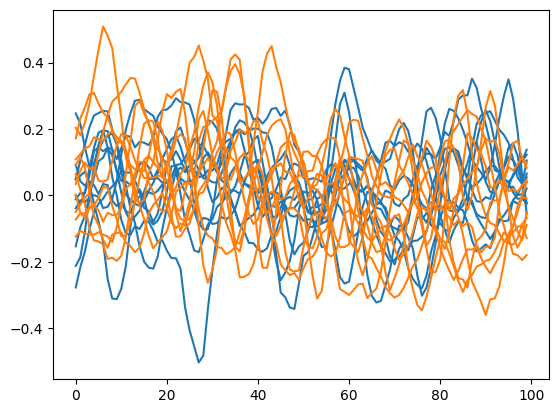

In [41]:
plt.plot(lsc1_ens[0:10].T, c='C0')
plt.plot(rtest[0:10].T, c='C1')
plt.show()